In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Configuration and paths

In [2]:
# Source specifications
source_name = "crab"

# Run number
run_bad  = 6172
run_good = 3270

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_scaling_correlations/"
# Data main directory
root_data = root + f"../../data/cosmic_ray_data_correction/{source_name}/"

# directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"
dir_dl3  = root_data + "dl3/"
dir_irfs = root_data + "irfs/"

# Read datacheck data

In [4]:
dcheck_good = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20201215.h5"
dcheck_bad  = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210908.h5"

dcheck_good = pd.read_hdf(dcheck_good, key="cosmics_intensity_spectrum").query(f"runnumber == {run_good}")
dcheck_bad  = pd.read_hdf(dcheck_bad,  key="cosmics_intensity_spectrum").query(f"runnumber == {run_bad}")
dcheck_good[:4]

,yyyymmdd,ra_tel,dec_tel,cos_zenith,az_tel,runnumber,subrun,time,elapsed_time,corrected_elapsed_time,delta_t_exp_index,cosmics_rate,cosmics_cleaned_rate,intensity_at_half_peak_rate,intensity_at_peak_rate,ZD_corrected_intensity_at_half_peak_rate,cosmics_peak_rate,ZD_corrected_cosmics_peak_rate,cosmics_rate_at_422_pe,delta_cosmics_rate_at_422_pe,ZD_corrected_cosmics_rate_at_422_pe,ZD_corrected_delta_cosmics_rate_at_422_pe,cosmics_spectral_index,delta_cosmics_spectral_index,ZD_corrected_cosmics_spectral_index,intensity_spectrum_fit_p_value,intensity_at_reference_rate,light_yield,diffuse_nsb_std,num_star_affected_pixels,anomalous_low_intensity_peak
568,20201215,83.264558,21.787625,0.859349,1.664841,3270,0,1.608073e+09,10.776082,10.776082,5195.124057,4726.485813,4097.871459,44.467226,66.940365,43.408896,28.844706,37.966819,1.647863,0.023303,1.785560,0.025250,-2.260128,0.086991,-2.209210,0.469526,426.966221,1.021605,1.773901,120,False
569,20201215,83.266563,21.787694,0.859685,1.665306,3270,1,1.608073e+09,10.856308,10.856308,5285.489642,4689.623978,4066.115479,45.242468,66.940365,44.168936,28.763404,37.841589,1.619586,0.015416,1.754496,0.016701,-2.337725,0.058057,-2.286945,0.768944,423.533675,1.006467,1.774722,120,False
570,20201215,83.264628,21.787404,0.860052,1.665827,3270,2,1.608073e+09,10.879756,10.879756,5225.465917,4679.516618,4073.528775,45.766791,66.940365,44.684354,28.439886,37.395726,1.634921,0.033413,1.770641,0.036187,-2.311151,0.125410,-2.260521,0.151818,425.271485,1.013945,1.773967,121,False
571,20201215,83.260643,21.787750,0.860436,1.666351,3270,3,1.608073e+09,10.839594,10.839594,5137.371244,4696.670319,4079.765302,44.724152,74.684021,43.669687,28.882980,37.952988,1.594936,0.022572,1.726861,0.024439,-2.388429,0.085416,-2.337957,0.482166,420.634096,0.994351,1.773526,122,False


# Read 1 subrun data

In [5]:
tables = []
for srun in [0,1,2,3]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables.append(table)

tables_good = []
for srun in [0]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_good:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables_good.append(table)

## Calculate the rates and save the histogams and other data of each subrun

In [30]:
bins = np.linspace(1,5,200)
bins_c = bins[:-1] / 2 + bins[1:] / 2

histograms_good = []
histograms_bad  = []
zds_good, azs_good = [], []
zds_bad, azs_bad   = [], []
for srun, tab in enumerate(tables):
    tsrun_datacheck = dcheck_bad.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_bad.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_bad.append(np.rad2deg(np.arccos(coszd)))
    azs_bad.append(tsrun_datacheck["az_tel"].iloc[0])

for srun, tab in enumerate(tables_good):
    tsrun_datacheck = dcheck_good.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_good.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_good.append(np.rad2deg(np.arccos(coszd)))
    azs_good.append(tsrun_datacheck["az_tel"].iloc[0])


## Plot the cosmics rates

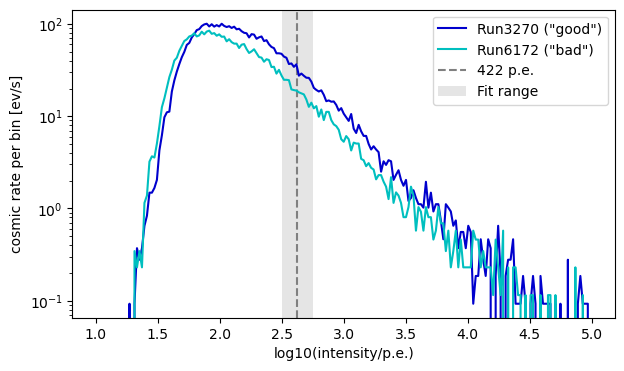

In [31]:
fig, (ax) = plt.subplots(figsize=(7,4))

for srun, tab in enumerate(tables_good):
    ax.plot(bins_c, histograms_good[srun], color="mediumblue", label=f"Run{run_good} (\"good\")" if srun == 0 else "")
    
for srun, tab in enumerate(tables[:1]):
    ax.plot(bins_c, histograms_bad[srun], color="c", label=f"Run{run_bad} (\"bad\")" if srun == 0 else "")

ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, label="Fit range", lw=0)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

RATIO = 1.6383


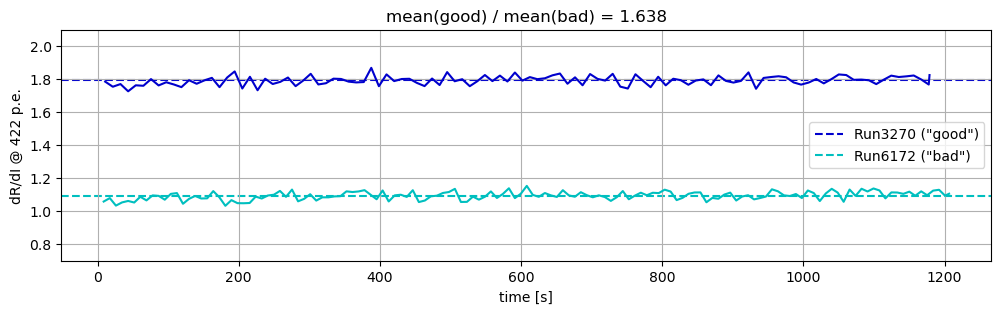

In [32]:
rate_good = np.array(dcheck_good["ZD_corrected_cosmics_rate_at_422_pe"])
rate_bad  = np.array(dcheck_bad["ZD_corrected_cosmics_rate_at_422_pe"])
elpt_good, elpt_bad = np.cumsum(dcheck_good["elapsed_time"]), np.cumsum(dcheck_bad["elapsed_time"])
ratio = np.mean(rate_good)/np.mean(rate_bad)

print(f"RATIO = {ratio:.4f}")

fig, (ax) = plt.subplots(figsize=(12,3))

ax.plot(elpt_bad, rate_bad, color="c")
ax.plot(elpt_good, rate_good, color="mediumblue")
ax.axhline(np.mean(rate_good), ls="--", zorder=-3, color="mediumblue", label=f"Run{run_good} (\"good\")")
ax.axhline(np.mean(rate_bad), ls="--", zorder=-3, color="c", label=f"Run{run_bad} (\"bad\")")

ax.legend(loc=7)
ax.set_ylabel("dR/dI @ 422 p.e.")
ax.set_xlabel("time [s]")
ax.set_ylim(0.7, 2.1)
ax.grid()
ax.set_title(f"mean(good) / mean(bad) = {ratio:.3f}")

plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
print([*np.linspace(1-0.6383, 1, 5)[:-1], *np.linspace(1, 1.6383, 5),*np.linspace(1.6383, 2, 5)[1:]])

[0.3617, 0.521275, 0.68085, 0.840425, 1.0, 1.159575, 1.31915, 1.478725, 1.6383, 1.728725, 1.81915, 1.909575, 2.0]


In [34]:
histograms = []
hist_npix  = []
bins_n = np.linspace(2, 1855, 1855-2)
scales = [0.3617, 0.521275, 0.68085, 0.840425, 1.0, 1.159575, 1.31915, 1.478725, 1.6383, 1.728725, 1.81915, 1.909575, 2]
for scale in scales:
    ext = f"_scaled{scale:.4f}" if scale != 1.0 else ""
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{0:04}{ext}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 

    datacheck = dcheck_bad.query(f"subrun == 0")
    counts, bin_edges = np.histogram(table["log_intensity"], bins=bins)
    rates = counts / float(datacheck["corrected_elapsed_time"].iloc[0])

    counts_npix, _ = np.histogram(table["n_pixels"], bins=bins_n)
    rates_npix = counts_npix / float(datacheck["corrected_elapsed_time"].iloc[0])
    
    histograms.append(rates)
    hist_npix.append(rates_npix)
    
hist_good_npix, _ = np.histogram(tables[0]["n_pixels"], bins=bins_n)

In [42]:
(np.array(scales)-1)*100

array([-63.83  , -47.8725, -31.915 , -15.9575,   0.    ,  15.9575,
        31.915 ,  47.8725,  63.83  ,  72.8725,  81.915 ,  90.9575,
       100.    ])

In [51]:
X = [216.        , 221.51515152, 227.03030303, 232.54545455,
       238.06060606, 243.57575758, 249.09090909, 254.60606061,
       260.12121212, 265.63636364, 271.15151515, 276.66666667,
       282.18181818, 287.6969697 , 293.21212121, 298.72727273,
       304.24242424, 309.75757576, 315.27272727, 320.78787879,
       326.3030303 , 331.81818182, 337.33333333, 342.84848485,
       348.36363636, 353.87878788, 359.39393939, 364.90909091,
       370.42424242, 375.93939394, 381.45454545, 386.96969697,
       392.48484848, 398.        , 403.51515152, 409.03030303,
       414.54545455, 420.06060606, 425.57575758, 431.09090909,
       436.60606061, 442.12121212, 447.63636364, 453.15151515,
       458.66666667, 464.18181818, 469.6969697 , 475.21212121,
       480.72727273, 486.24242424, 491.75757576, 497.27272727,
       502.78787879, 508.3030303 , 513.81818182, 519.33333333,
       524.84848485, 530.36363636, 535.87878788, 541.39393939,
       546.90909091, 552.42424242, 557.93939394, 563.45454545,
       568.96969697, 574.48484848, 580.        , 585.51515152,
       591.03030303, 596.54545455, 602.06060606, 607.57575758,
       613.09090909, 618.60606061, 624.12121212, 629.63636364,
       635.15151515, 640.66666667, 646.18181818, 651.6969697 ,
       657.21212121, 662.72727273, 668.24242424, 673.75757576,
       679.27272727, 684.78787879, 690.3030303 , 695.81818182,
       701.33333333, 706.84848485, 712.36363636, 717.87878788,
       723.39393939, 728.90909091, 734.42424242, 739.93939394,
       745.45454545, 750.96969697, 756.48484848, 762.        ]
Y = [5.21020255, 4.92534671, 4.6625074 , 4.41950832, 4.19443308,
       3.98558902, 3.79147682, 3.6107647 , 3.44226663, 3.28492371,
       3.13778825, 3.00001015, 2.87082514, 2.74954468, 2.63554716,
       2.5282703 , 2.42720456, 2.33188728, 2.2418977 , 2.15685249,
       2.07640183, 2.00022602, 1.9280324 , 1.85955269, 1.79454062,
       1.73276979, 1.67403179, 1.61813454, 1.56490078, 1.51416672,
       1.46578084, 1.41960283, 1.3755026 , 1.33335938, 1.293061  ,
       1.25450311, 1.21758857, 1.18222684, 1.14833348, 1.11582967,
       1.08464173, 1.05470076, 1.02594226, 0.99830583, 0.97173481,
       0.94617605, 0.92157964, 0.89789866, 0.87508902, 0.85310919,
       0.83192009, 0.81148486, 0.79176877, 0.77273904, 0.7543647 ,
       0.73661651, 0.71946682, 0.70288946, 0.68685969, 0.67135405,
       0.65635032, 0.64182745, 0.62776544, 0.61414533, 0.60094911,
       0.58815967, 0.57576074, 0.56373685, 0.55207329, 0.54075604,
       0.52977176, 0.51910773, 0.50875185, 0.49869254, 0.48891879,
       0.47942007, 0.47018634, 0.46120799, 0.45247586, 0.44398118,
       0.43571555, 0.42767097, 0.41983975, 0.41221454, 0.4047883 ,
       0.39755429, 0.39050605, 0.38363736, 0.3769423 , 0.37041516,
       0.36405046, 0.35784296, 0.3517876 , 0.34587953, 0.34011411,
       0.33448686, 0.32899346, 0.32362979, 0.31839186, 0.31327583]

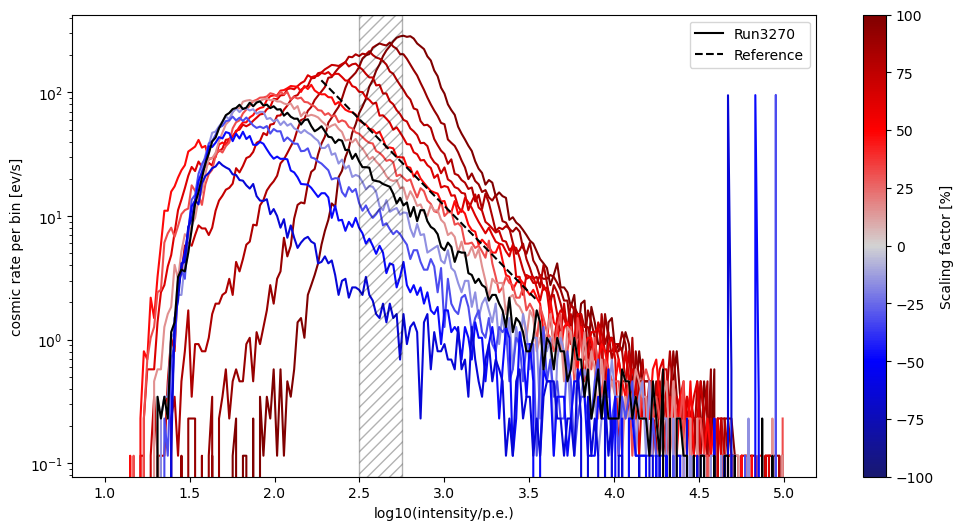

In [79]:
fig, (ax) = plt.subplots(figsize=(12,6))

# ax.plot(bins_c, histograms_good[0], color="k", ls=":", label=f"Run{run_good} (\"good\")", zorder=100)
ax.plot(bins_c, histograms[4], color="k", ls="-", label=f"Run{run_good}" if srun == 0 else "", zorder=100)

pcols = ["midnightblue", "b", "lightgray", "r", "maroon"]
colors = aux.get_colors_multiplot((np.array(scales)-1)*100, COLORS=pcols, ran=[-100, 100])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [-100, 100], cmap, label="Scaling factor [%]")

for i, scale in enumerate(scales):
    label = "" #f"Scaled {scale:.3f}"
    kw = dict()
    ax.plot(bins_c, histograms[i], color=colors[i], label=label, zorder=-i, **kw)

# ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
# ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, lw=0)

lims_intensity = [316, 562]                  # limits for the fit
ax.axvspan(np.log10(lims_intensity[0]), np.log10(lims_intensity[1]), alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k", 
           label="Fit range" if i in [0] else "")
ax.plot(np.log(X)-3.1, np.array(Y)*13/np.array(X)*400, 
        color="k", ls="--", zorder=10, label="Reference")

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_30472/2453398871.py:23: RuntimeWarning: divide by zero encountered in log10
  fit = np.poly1d(np.polyfit(x, np.log10(y), 1))


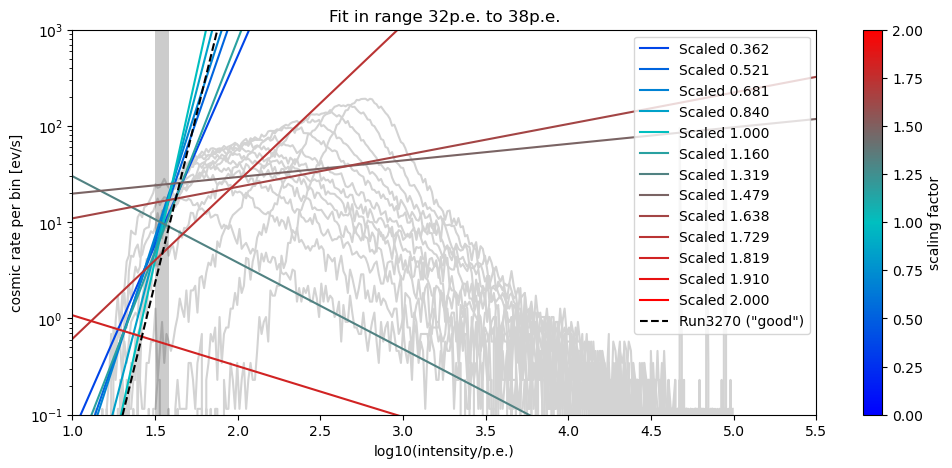

In [28]:
binlims = [37, 44]

fig, (ax) = plt.subplots(figsize=(12,5))


for i, scale in enumerate(scales):
    ax.plot(bins_c, histograms[i], color="lightgray",zorder=-100,)
    
    
pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")


slopes = []
intercepts = []
for i, scale in enumerate(scales):
    
    x = bins_c[binlims[0]:binlims[1]]
    y = histograms[i][binlims[0]:binlims[1]]
    
    fit = np.poly1d(np.polyfit(x, np.log10(y), 1)) 
    
    slopes.append(fit[0])
    intercepts.append(fit(np.log10(422)))
        
    xx = np.linspace(0, 6)
    ax.plot(xx, 10**fit(xx), color=colors[i], label = f"Scaled {scale:.3f}")
    
fitgood = np.poly1d(np.polyfit(x, np.log10(histograms_good[0][binlims[0]:binlims[1]]), 1)) 
slopesgood = fitgood[0]
interceptsgood = fitgood(np.log10(422))


ax.plot(xx, 10**fitgood(xx), color="k", ls="--", label=f"Run{run_good} (\"good\")")
ax.axvspan(bins_c[binlims[0]:binlims[1]][0], bins_c[binlims[0]:binlims[1]][-1], color="k", alpha=0.2, ls="")

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")
ax.set_ylim(1e-1, 1e3)
ax.set_xlim(1,5.5)
ax.set_title(f"Fit in range {10**bins_c[binlims[0]:binlims[1]][0]:.0f}p.e. to {10**bins_c[binlims[0]:binlims[1]][-1]:.0f}p.e.")

plt.show()

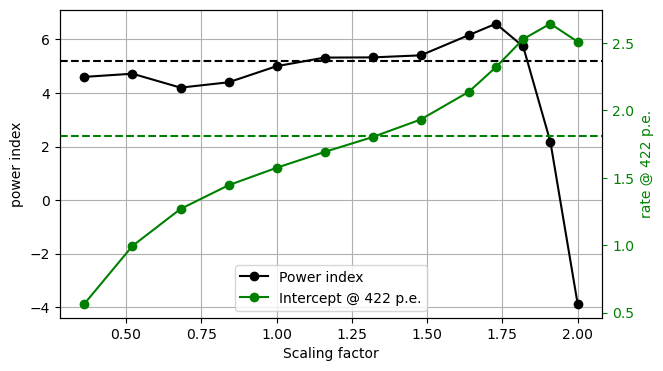

In [28]:
fig, (ax) = plt.subplots(figsize=(7,4))
axt = ax.twinx()

p1, = ax.plot(scales, slopes, color="k", marker="o", label="Power index")
p2, = axt.plot(scales, intercepts, color="g", marker="o", label="Power index")
ax.plot([], [], color="g", marker="o", label="Intercept @ 422 p.e.")
ax.axhline(slopesgood, color="k", ls="--")
ax.plot([], [], color="g", ls="--")
axt.axhline(interceptsgood, color="g", ls="--")

ax.legend(loc=8)
ax.set_ylabel("power index")
axt.set_ylabel("rate @ 422 p.e.")
ax.set_xlabel("Scaling factor")
ax.grid()
ax.yaxis.label.set_color(p1.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
axt.yaxis.label.set_color(p2.get_color())
axt.tick_params(axis='y', colors=p2.get_color())

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

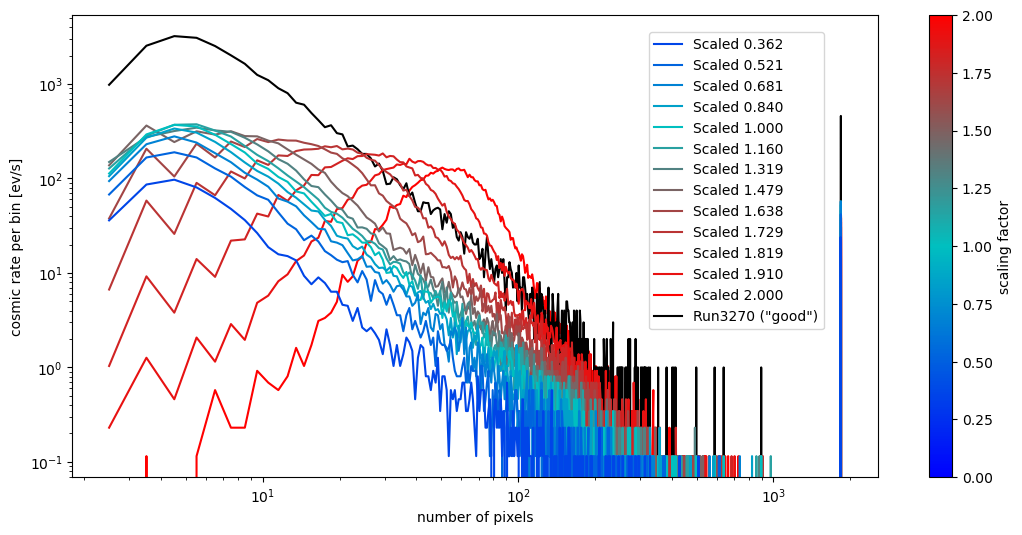

In [29]:
fig, (ax) = plt.subplots(figsize=(13,6))

pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    ax.plot(bins_n[1:]/2+bins_n[:-1]/2, hist_npix[i], color=colors[i], label=f"Scaled {scale:.3f}", zorder=-i,)

ax.plot(bins_n[1:]/2+bins_n[:-1]/2, hist_good_npix, color="k", zorder=-i, label=f"Run{run_good} (\"good\")")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0, 250)
ax.legend(loc=(0.715, 0.32))
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("number of pixels")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
bins_nn = np.logspace(np.log10(2), np.log10(1855), 50)

hist_nnpix  = []
for scale in scales:
    ext = f"_scaled{scale:.4f}" if scale != 1.0 else ""
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{0:04}{ext}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 

    counts_npix, _ = np.histogram(table["n_pixels"], bins=bins_nn)
    rates_npix = counts_npix / float(datacheck["corrected_elapsed_time"].iloc[0])

    hist_nnpix.append(rates_npix)
    
hist_good_nnpix, _ = np.histogram(tables[0]["n_pixels"], bins=bins_nn)

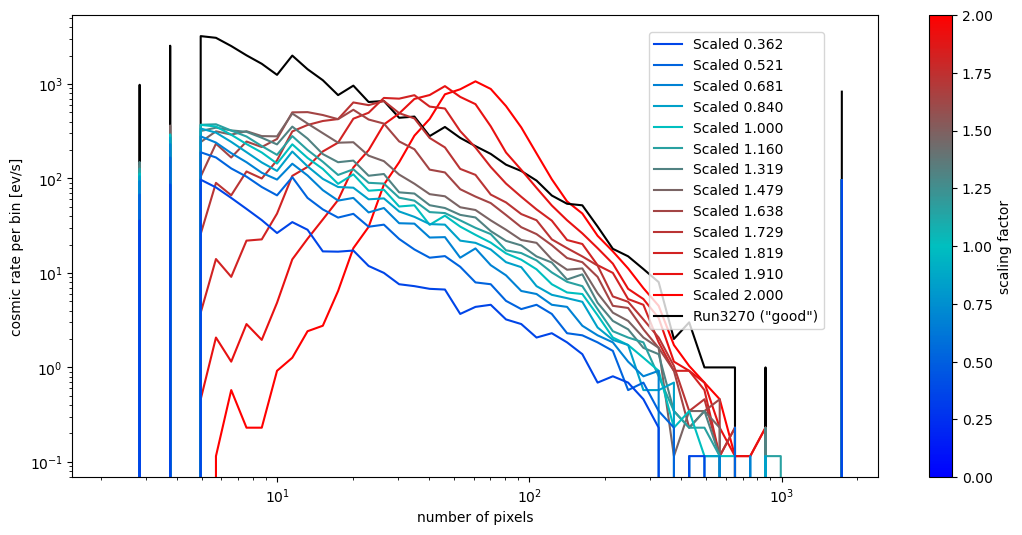

In [25]:
fig, (ax) = plt.subplots(figsize=(13,6))

pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    ax.plot(bins_nn[1:]/2+bins_nn[:-1]/2, hist_nnpix[i], color=colors[i], label=f"Scaled {scale:.3f}", zorder=-i,)

ax.plot(bins_nn[1:]/2+bins_nn[:-1]/2, hist_good_nnpix, color="k", zorder=-i, label=f"Run{run_good} (\"good\")")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0, 250)
ax.legend(loc=(0.715, 0.32))
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("number of pixels")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()